# Taxi Data Exploration

#### Import packages and spark session

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.window import Window as Window

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('ziyoda-eda').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

In [3]:
spark

### Import data and union

In [4]:
df_2018 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2018.csv", inferSchema=True, header=True)
df_2019 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2019.csv", inferSchema=True, header=True)
df_2020 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2020.csv", inferSchema=True, header=True)
df_2021 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2021.csv", inferSchema=True, header=True)
df_2022 = spark.read.csv("gs://big_data_taxi/taxi-data/taxi_2022.csv", inferSchema=True, header=True)

In [5]:
df_taxi = df_2018.union(df_2019)

In [5]:
df_taxi = df_2019.union(df_2020).union(df_2021).union(df_2022).union(df_2018)

### Initial exploration and data cleaning

Start off by just taking a look at the schema, dtypes, missing values etc.

In [6]:
df_taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [9]:
df_taxi.count()

37209453

In [10]:
df_taxi.show(2, vertical = True)

-RECORD 0------------------------------------------
 Trip ID                    | fe928266cfcb233dd... 
 Taxi ID                    | 8b5e321e89ba9e3ea... 
 Trip Start Timestamp       | 01/01/2018 12:00:... 
 Trip End Timestamp         | 01/01/2018 12:00:... 
 Trip Seconds               | 0                    
 Trip Miles                 | 0.0                  
 Pickup Census Tract        | null                 
 Dropoff Census Tract       | null                 
 Pickup Community Area      | null                 
 Dropoff Community Area     | null                 
 Fare                       | 12.0                 
 Tips                       | 3.0                  
 Tolls                      | 0.0                  
 Extras                     | 0.0                  
 Trip Total                 | 15.0                 
 Payment Type               | Credit Card          
 Company                    | Suburban Dispatch... 
 Pickup Centroid Latitude   | null                 
 Pickup Cent

In [11]:
df_taxi.select([count(c).alias(c) for c in df_taxi.columns]).show(vertical = True)

-RECORD 0------------------------------
 Trip ID                    | 37209453 
 Taxi ID                    | 37209453 
 Trip Start Timestamp       | 37209453 
 Trip End Timestamp         | 37208558 
 Trip Seconds               | 37204305 
 Trip Miles                 | 37208211 
 Pickup Census Tract        | 25224682 
 Dropoff Census Tract       | 25042299 
 Pickup Community Area      | 34542149 
 Dropoff Community Area     | 33666198 
 Fare                       | 37206585 
 Tips                       | 37206585 
 Tolls                      | 32747681 
 Extras                     | 37206585 
 Trip Total                 | 37206585 
 Payment Type               | 37209453 
 Company                    | 37209453 
 Pickup Centroid Latitude   | 34549282 
 Pickup Centroid Longitude  | 34549282 
 Pickup Centroid Location   | 34549282 
 Dropoff Centroid Latitude  | 33795007 
 Dropoff Centroid Longitude | 33795007 
 Dropoff Centroid  Location | 33795007 



Data is fairly populated, other than some of the centroid and census tract data. We probably won't use these anyway so can drop those

Next drop some of the extraneous columns, and change some dtypes to appropriate dates etc.

In [7]:
df_taxi = df_taxi.drop('Pickup Centroid Location','Dropoff Centroid  Location',
                      'Pickup Census Tract', 'Dropoff Census Tract')

In [8]:
df_taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)



In [9]:
df_taxi = df_taxi.withColumn('Trip Start Timestamp',F.to_timestamp(col('Trip Start Timestamp'),"MM/dd/yyyy hh:mm:ss a"))
df_taxi = df_taxi.withColumn('Trip End Timestamp',F.to_timestamp(col('Trip End Timestamp'),"MM/dd/yyyy hh:mm:ss a"))

#### Augment the data with some helper date columns and the actual community names versus the numbers

In [10]:
df_communities = spark.read.csv('gs://big_data_taxi/taxi-data/community.csv', inferSchema=True, header=True)

In [11]:
df_taxi = df_taxi.join(df_communities, df_taxi['Pickup Community Area'] == df_communities['community_id'], 
                       "left_outer")

df_taxi = df_taxi.drop('community_id').withColumnRenamed('community_name','Pickup Community Name')

In [12]:
df_taxi = df_taxi.join(df_communities, df_taxi['Dropoff Community Area'] == df_communities['community_id'], 
                       "left_outer")

df_taxi = df_taxi.drop('community_id').withColumnRenamed('community_name','Dropoff Community Name')

In [13]:
df_taxi = df_taxi.withColumn('Ride Month',F.month(col('Trip Start Timestamp')))
df_taxi = df_taxi.withColumn('Ride Year',F.year(col('Trip Start Timestamp')))
df_taxi = df_taxi.withColumn('Ride Day of Week', F.dayofweek('Trip Start Timestamp'))
df_taxi = df_taxi.withColumn('Ride Date', F.to_date('Trip Start Timestamp'))
df_taxi = df_taxi.withColumn('Ride Month Year',F.concat_ws('-',col('Ride Year'),F.lpad(col('Ride Month'),2,'0')))

### Now lets take a look at the fare distribution and average fare

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns

In [15]:
df_taxi.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: timestamp (nullable = true)
 |-- Trip End Timestamp: timestamp (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)
 |-- Pickup Community Name: string (nullable = true)
 |-- Dropoff Community Name: string (nullable = true)
 |-- R

In [16]:
#Narrow down data to fare related variables
df_short=df_taxi.select('Tips', 'Fare', 'Trip Miles','Trip Seconds',
                        'Tolls','Extras','Trip Total', 'Pickup Community Name', 'Dropoff Community Name', 
                        'Ride Month', 'Ride Year', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 
                       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude' )

#### Average fare cost for the whole dataset is $15.21

In [16]:
from pyspark.sql.functions import avg
df_short.select(avg('Fare')).show()

+------------------+
|         avg(Fare)|
+------------------+
|15.208866995300994|
+------------------+



In [17]:
df_short.show(1, vertical = True)

-RECORD 0---------------------------
 Tips                       | 0.0   
 Fare                       | 12.75 
 Trip Miles                 | 3.45  
 Trip Seconds               | 885   
 Tolls                      | 0.0   
 Extras                     | 4.0   
 Trip Total                 | 16.75 
 Pickup Community Name      | null  
 Dropoff Community Name     | null  
 Ride Month                 | 1     
 Ride Year                  | 2019  
 Pickup Centroid Latitude   | null  
 Pickup Centroid Longitude  | null  
 Dropoff Centroid Latitude  | null  
 Dropoff Centroid Longitude | null  
only showing top 1 row



In [25]:
#check for null values
df_short.filter(col("Trip Miles").isNull()).show()

+----+-----+----------+------------+-----+------+----------+---------------------+----------------------+----------+---------+------------------------+-------------------------+-------------------------+--------------------------+
|Tips| Fare|Trip Miles|Trip Seconds|Tolls|Extras|Trip Total|Pickup Community Name|Dropoff Community Name|Ride Month|Ride Year|Pickup Centroid Latitude|Pickup Centroid Longitude|Dropoff Centroid Latitude|Dropoff Centroid Longitude|
+----+-----+----------+------------+-----+------+----------+---------------------+----------------------+----------+---------+------------------------+-------------------------+-------------------------+--------------------------+
| 0.0| 3.25|      null|           0|  0.0|   0.0|      3.25|          Irving Park|           Irving Park|         1|     2018|            41.953582125|             -87.72345239|             41.953582125|              -87.72345239|
|null| null|      null|         470| null|  null|      null|                

#### Most of the columns have null values, if we don't remove or replace them analysis and model will not run. As we have enough dataset and the computation power of gcp pyspark decided to drop null values 

In [17]:
df_short1 = df_short.where(col('Tips').isNotNull())
df_short1 = df_short1.where(col('Fare').isNotNull())
df_short1 = df_short1.where(col('Trip Miles').isNotNull())
df_short1 = df_short1.where(col('Trip Seconds').isNotNull())
df_short1 = df_short1.where(col('Tolls').isNotNull())
df_short1 = df_short1.where(col('Extras').isNotNull())
df_short1 = df_short1.where(col('Trip Total').isNotNull())
df_short1 = df_short1.where(col('Pickup Community Name').isNotNull())
df_short1 = df_short1.where(col('Dropoff Community Name').isNotNull())
df_short1 = df_short1.where(col('Ride Month').isNotNull())
df_short1 = df_short1.where(col('Ride Year').isNotNull())
df_short1 = df_short1.where(col('Pickup Centroid Latitude').isNotNull())
df_short1 = df_short1.where(col('Pickup Centroid Longitude').isNotNull())
df_short1 = df_short1.where(col('Dropoff Centroid Latitude').isNotNull())
df_short1 = df_short1.where(col('Dropoff Centroid Longitude').isNotNull())

In [26]:
df_short1.filter(col("Trip Total").isNull()).show()

+----+----+----------+------------+-----+------+----------+---------------------+----------------------+----------+---------+------------------------+-------------------------+-------------------------+--------------------------+
|Tips|Fare|Trip Miles|Trip Seconds|Tolls|Extras|Trip Total|Pickup Community Name|Dropoff Community Name|Ride Month|Ride Year|Pickup Centroid Latitude|Pickup Centroid Longitude|Dropoff Centroid Latitude|Dropoff Centroid Longitude|
+----+----+----------+------------+-----+------+----------+---------------------+----------------------+----------+---------+------------------------+-------------------------+-------------------------+--------------------------+
+----+----+----------+------------+-----+------+----------+---------------------+----------------------+----------+---------+------------------------+-------------------------+-------------------------+--------------------------+



In [19]:
df_short1.count()

37785843

In [28]:
df_short1.printSchema()

root
 |-- Tips: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Pickup Community Name: string (nullable = true)
 |-- Dropoff Community Name: string (nullable = true)
 |-- Ride Month: integer (nullable = true)
 |-- Ride Year: integer (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)



In [ ]:
### Now check the distributon of the fare

In [69]:
#Sampling data and running EDA on 2022 as gcp coputation couldn't handle all data from 2018-2022

pdf_2022 = df_short1.filter(df_short1['Ride Year'] == '2022').toPandas()
#pdf_2022.to_csv('gs://big_data_taxi/taxi-data/fare2022.csv')

<AxesSubplot:>

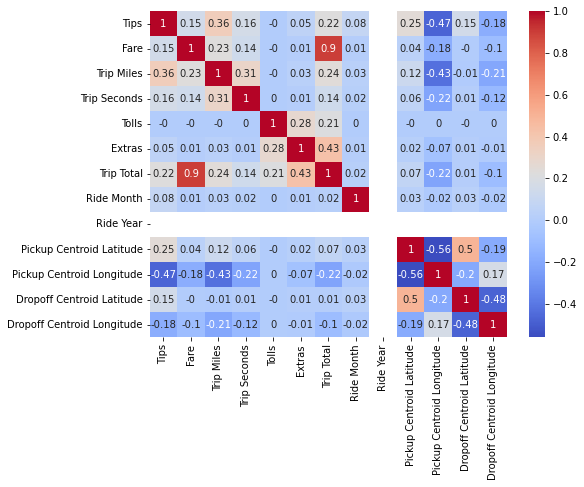

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
import seaborn as sns
sns.heatmap(np.round(pdf_2022.corr(),2), annot = True, fmt='.2g',cmap= 'coolwarm')

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


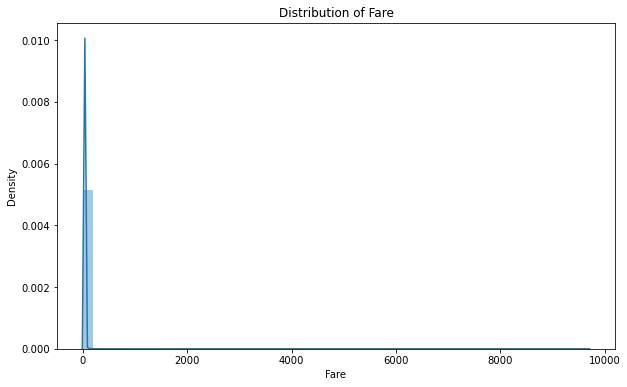

In [71]:
#Plot fare distribution
plt.figure(figsize = (10, 6))

sns.distplot(pdf_2022['Fare']);

plt.title('Distribution of Fare');

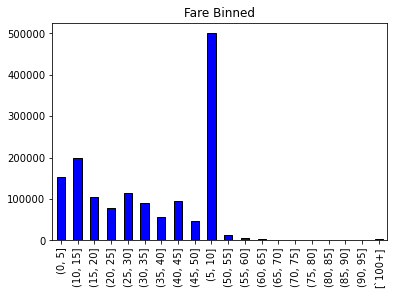

In [72]:
# Bin fare to see buckets for fare in range of $5
# Bin the fare and convert to string

pdf_2022['fare-bin'] = pd.cut(pdf_2022['Fare'], bins = list(range(0, 100, 5))).astype(str)

# Uppermost bin

pdf_2022.loc[pdf_2022['fare-bin'] == 'nan', 'fare-bin'] = '[`100+]'

# Adjust bin so the sorting is correct

pdf_2022.loc[pdf_2022['fare-bin'] == '(5.0, 10.0]', 'fare-bin'] = '(05.0, 10.0]'

# Bar plot of value counts

pdf_2022['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');

plt.title('Fare Binned');

#### Density plot for the fare shows that there are outliers and fare is left skewed. The bins show that the most of the fare costs fall in range between $0-$60. Also, there is very low  correlation between other variables and fare.  Thus, we filter the fare to be less than $65. 

In [73]:
df_66 = df_short1.filter(df_short1['Fare']< '65')

In [84]:
df_66.show(vertical = True)

-RECORD 0-------------------------------------
 Tips                       | 3.0             
 Fare                       | 9.0             
 Trip Miles                 | 0.0             
 Trip Seconds               | 600             
 Tolls                      | 0.0             
 Extras                     | 1.0             
 Trip Total                 | 13.0            
 Pickup Community Name      | Near North Side 
 Dropoff Community Name     | Loop            
 Ride Month                 | 1               
 Ride Year                  | 2019            
 Pickup Centroid Latitude   | 41.891971508    
 Pickup Centroid Longitude  | -87.612945414   
 Dropoff Centroid Latitude  | 41.880994471    
 Dropoff Centroid Longitude | -87.632746489   
-RECORD 1-------------------------------------
 Tips                       | 0.0             
 Fare                       | 29.5            
 Trip Miles                 | 0.6             
 Trip Seconds               | 1260            
 Tolls       

<AxesSubplot:>

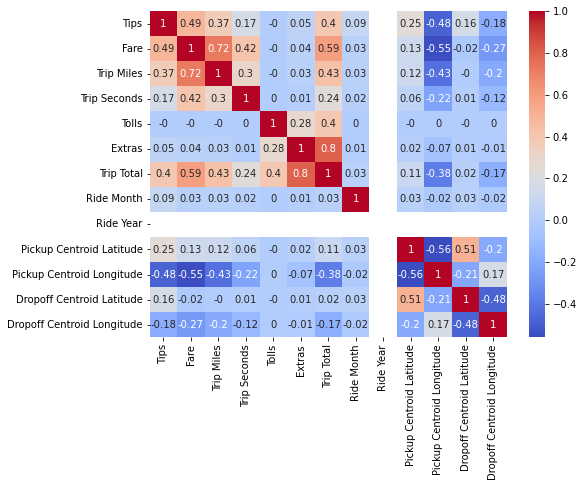

In [87]:
#Rerun corrolation

df_fare=pdf_2022['Fare']<65
filtered_df = pdf_2022[df_fare]

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(np.round(filtered_df.corr(),2), annot = True, fmt='.2g',cmap= 'coolwarm')

In [78]:
df_fare = df_66.select('Fare', 'Ride Month', 'Ride Year')
df_fare = df_fare.groupBy('Ride Month', 'Ride Year').avg()
df_fare = df_fare.select('Ride Month', 'Ride Year', 'avg(Fare)')

In [79]:
pdf_fare = df_fare.toPandas()

In [80]:
pdf_fare['date'] = pd.to_datetime(pdf_fare['Ride Month'].astype(str)+'-01'+'-'+pdf_fare['Ride Year'].astype(str))

In [81]:
pdf_fare = pdf_fare.sort_values(by='date')

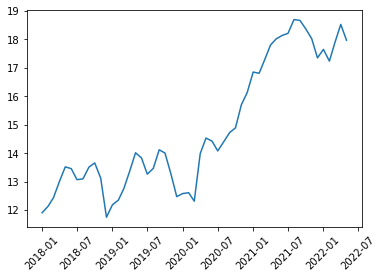

In [82]:
#Plot average fare over the years 2018-2019
plt.plot(pdf_fare['date'],pdf_fare['avg(Fare)'])
plt.xticks(rotation = 45)
plt.show()

#### New average after dropping null variable and filtering fare to be less than $65, new average fare is 13.74

In [77]:
from pyspark.sql.functions import avg
df_66.select(avg('Fare')).show()

+------------------+
|         avg(Fare)|
+------------------+
|13.739393855904636|
+------------------+



## Model 1: Linear Regression

In [54]:
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#convert relevant categorical into one hot encoded
indexer1 = StringIndexer(inputCol="Pickup Community Name", outputCol="PickupIdx").setHandleInvalid("skip")
indexer2 = StringIndexer(inputCol="Dropoff Community Name", outputCol="DropoffIdx").setHandleInvalid("skip")
indexer3 = StringIndexer(inputCol="Pickup Centroid Latitude", outputCol="PickLatIdx").setHandleInvalid("skip")
indexer4 = StringIndexer(inputCol="Pickup Centroid Longitude", outputCol="PickLongIdx").setHandleInvalid("skip")
indexer5 = StringIndexer(inputCol="Dropoff Centroid Latitude", outputCol="DropLatIdx").setHandleInvalid("skip")
indexer6 = StringIndexer(inputCol="Dropoff Centroid Longitude", outputCol="DropLongIdx").setHandleInvalid("skip")

#gather all indexers as inputs to the One Hot Encoder
inputs = [indexer1.getOutputCol(), indexer2.getOutputCol(),indexer3.getOutputCol(), indexer4.getOutputCol(), indexer5.getOutputCol(), indexer6.getOutputCol()]

#create the one hot encoder
encoder = OneHotEncoder(inputCols=inputs,  \
                                 outputCols=["PickupVec", "DropoffVec", "PickLatVec", "PickLongVec","DropLatVec", "DropLongVec"])

#run it through a pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, indexer6, encoder])
encodedData = pipeline.fit(df_66).transform(df_66)

encodedData.show(1, vertical = True)

-RECORD 0--------------------------------------
 Tips                       | 3.0              
 Fare                       | 9.0              
 Trip Miles                 | 0.0              
 Trip Seconds               | 600              
 Tolls                      | 0.0              
 Extras                     | 1.0              
 Trip Total                 | 13.0             
 Pickup Community Name      | Near North Side  
 Dropoff Community Name     | Loop             
 Ride Month                 | 1                
 Ride Year                  | 2019             
 Pickup Centroid Latitude   | 41.891971508     
 Pickup Centroid Longitude  | -87.612945414    
 Dropoff Centroid Latitude  | 41.880994471     
 Dropoff Centroid Longitude | -87.632746489    
 PickupIdx                  | 0.0              
 DropoffIdx                 | 1.0              
 PickLatIdx                 | 24.0             
 PickLongIdx                | 24.0             
 DropLatIdx                 | 0.0       

In [55]:
#gather feature vector and identify features
assembler = VectorAssembler(inputCols = ['Tips', 'Trip Miles', 'Trip Seconds', 'Tolls','Extras', 'PickupVec', 'DropoffVec', 'PickLatVec', 'DropLatVec', 'DropLongVec'], \
                            outputCol = 'features')

encodedData = assembler.transform(encodedData)

In [56]:
#Split into train and test
train_df, test_df = encodedData.randomSplit([.8,.2],seed=1234)
train_df.show(1, vertical = True)

-RECORD 0------------------------------------------
 Tips                       | 0.0                  
 Fare                       | 0.0                  
 Trip Miles                 | 0.0                  
 Trip Seconds               | 0                    
 Tolls                      | 0.0                  
 Extras                     | 0.0                  
 Trip Total                 | 0.0                  
 Pickup Community Name      | Bridgeport           
 Dropoff Community Name     | Bridgeport           
 Ride Month                 | 1                    
 Ride Year                  | 2019                 
 Pickup Centroid Latitude   | 41.836150155         
 Pickup Centroid Longitude  | -87.648787952        
 Dropoff Centroid Latitude  | 41.836150155         
 Dropoff Centroid Longitude | -87.648787952        
 PickupIdx                  | 44.0                 
 DropoffIdx                 | 34.0                 
 PickLatIdx                 | 86.0                 
 PickLongIdx

In [23]:
#Running regression model

%%time
from pyspark.ml.regression import LinearRegression

#Elastic Net
lr = LinearRegression(featuresCol = 'features', labelCol='Fare', regParam=0.3, elasticNetParam=0.8, maxIter=10)
lrm = lr.fit(train_df)

#model summary
print("RMSE: %f" % lrm.summary.rootMeanSquaredError)
print("r2: %f" % lrm.summary.r2)


22/05/30 03:48:52 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/30 03:48:52 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


RMSE: 6.034213
r2: 0.764136
CPU times: user 319 ms, sys: 84.7 ms, total: 404 ms
Wall time: 4min 2s


In [24]:
#make predictions
predictions = lrm.transform(test_df)

In [ ]:
#Evaluating model on test data

from pyspark.ml.evaluation import RegressionEvaluator

eval = RegressionEvaluator(labelCol="Fare", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(predictions, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 6.013


MSE: 37.386


MAE: 3.202


r2: 0.758


In [60]:
train_df.show()

+----+----+----------+------------+-----+------+----------+---------------------+----------------------+----------+---------+------------------------+-------------------------+-------------------------+--------------------------+---------+----------+----------+-----------+----------+-----------+---------------+---------------+-----------------+-----------------+-----------------+-----------------+--------------------+
|Tips|Fare|Trip Miles|Trip Seconds|Tolls|Extras|Trip Total|Pickup Community Name|Dropoff Community Name|Ride Month|Ride Year|Pickup Centroid Latitude|Pickup Centroid Longitude|Dropoff Centroid Latitude|Dropoff Centroid Longitude|PickupIdx|DropoffIdx|PickLatIdx|PickLongIdx|DropLatIdx|DropLongIdx|      PickupVec|     DropoffVec|       PickLatVec|      PickLongVec|       DropLatVec|      DropLongVec|            features|
+----+----+----------+------------+-----+------+----------+---------------------+----------------------+----------+---------+------------------------+------

## Model 2: Random Forest Regressor

In [ ]:
#Run Random Forest Regressor
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'Fare')
rfModel = rf.fit(train_df)


22/05/30 18:37:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1051.6 KiB
22/05/30 18:43:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1341.9 KiB
22/05/30 18:50:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1915.7 KiB


In [63]:
#Predict
predictions = rfModel.transform(test_df)


In [67]:
#Evaluate model on test data

from pyspark.ml.evaluation import RegressionEvaluator

eval = RegressionEvaluator(labelCol="Fare", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Absolute Error
mae = eval.evaluate(predictions, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 3.129


MAE: 1.670


r2: 0.937


## Appendix

### Running Linear Regression model on a dataset without filtering Fare to be less than $65. The r2 is very low at 0.04 and MAE is very high at 8.114.

In [68]:
import pyspark
def sparkShape(dataFrame):
    return (dataFrame.count(), len(dataFrame.columns))
pyspark.sql.dataframe.DataFrame.shape = sparkShape
print(df_short1.shape())

(37785843, 15)


In [76]:
from pyspark.ml.feature import VectorAssembler

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

#convert relevant categorical into one hot encoded
indexer1 = StringIndexer(inputCol="Company", outputCol="CompanyIdx").setHandleInvalid("skip")
indexer2 = StringIndexer(inputCol="Payment Type", outputCol="paytypeIdx").setHandleInvalid("skip")
indexer3 = StringIndexer(inputCol="Trip Seconds", outputCol="SecondsIdx").setHandleInvalid("skip")
indexer4 = StringIndexer(inputCol="Trip Miles", outputCol="MilesIdx").setHandleInvalid("skip")

#gather all indexers as inputs to the One Hot Encoder
inputs = [indexer1.getOutputCol(), indexer2.getOutputCol(), \
          indexer3.getOutputCol(), indexer4.getOutputCol()]

#create the one hot encoder
encoder = OneHotEncoder(inputCols=inputs,  \
                                 outputCols=["CompanyVec", "paytypeVec", \
                                             "SecondsVec", "MilesVec"])

#run it through a pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, encoder])
encodedData = pipeline.fit(df_taxi).transform(df_taxi)

#we have removed NAs so dont need to impute missing values.
#pipeline = pipeline.na.fill(0) 

encodedData.show(5, vertical = True)

22/05/26 06:15:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1303.4 KiB


-RECORD 0--------------------------------------
 Trip ID                | f24ef1302cd672bbc... 
 Taxi ID                | 1801165e22d31b0d2... 
 Trip Start Timestamp   | 2019-01-01 00:00:00  
 Trip End Timestamp     | 2019-01-01 00:15:00  
 Trip Seconds           | 885                  
 Trip Miles             | 3.45                 
 Pickup Community Area  | null                 
 Dropoff Community Area | null                 
 Fare                   | 12.75                
 Tips                   | 0.0                  
 Tolls                  | 0.0                  
 Extras                 | 4.0                  
 Trip Total             | 16.75                
 Payment Type           | Cash                 
 Company                | Flash Cab            
 Pickup Community Name  | null                 
 Dropoff Community Name | null                 
 Ride Month             | 1                    
 Ride Year              | 2019                 
 Ride Day of Week       | 3             

In [77]:
#gather feature vector and identify features
assembler = VectorAssembler(inputCols = ['CompanyVec', 'paytypeVec','SecondsVec', 'MilesVec'], \
                            outputCol = 'features')

encodedData = assembler.transform(encodedData)

In [87]:
encodedData.dropna().count()

22/05/26 06:24:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1316.1 KiB


26017604

In [88]:
#split data into train and test
encodedData = encodedData.drop(
'Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Pickup Community Name',
 'Dropoff Community Name',
 'Ride Day of Week',
 'Ride Date',
 'Ride Month Year')
encodedData = encodedData.dropna()
train_df, test_df = encodedData.randomSplit([.8,.2],seed=1234)
train_df.show(1)

22/05/26 06:25:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


+------------+----------+----+------------+--------------------+----------+---------+----------+----------+----------+--------+---------------+-------------+-----------------+----------------+--------------------+
|Trip Seconds|Trip Miles|Fare|Payment Type|             Company|Ride Month|Ride Year|CompanyIdx|paytypeIdx|SecondsIdx|MilesIdx|     CompanyVec|   paytypeVec|       SecondsVec|        MilesVec|            features|
+------------+----------+----+------------+--------------------+----------+---------+----------+----------+----------+--------+---------------+-------------+-----------------+----------------+--------------------+
|           0|       0.0| 0.0|        Cash|4053 - 40193 Adwa...|         1|     2019|      55.0|       0.0|       7.0|     0.0|(68,[55],[1.0])|(8,[0],[1.0])|(30777,[7],[1.0])|(8569,[0],[1.0])|(39422,[55,68,83,...|
+------------+----------+----+------------+--------------------+----------+---------+----------+----------+----------+--------+---------------+-

In [89]:
train_df.show(15, vertical = True)

22/05/26 06:26:16 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


-RECORD 0----------------------------
 Trip Seconds | 0                    
 Trip Miles   | 0.0                  
 Fare         | 0.0                  
 Payment Type | Cash                 
 Company      | 4053 - 40193 Adwa... 
 Ride Month   | 1                    
 Ride Year    | 2019                 
 CompanyIdx   | 55.0                 
 paytypeIdx   | 0.0                  
 SecondsIdx   | 7.0                  
 MilesIdx     | 0.0                  
 CompanyVec   | (68,[55],[1.0])      
 paytypeVec   | (8,[0],[1.0])        
 SecondsVec   | (30777,[7],[1.0])    
 MilesVec     | (8569,[0],[1.0])     
 features     | (39422,[55,68,83,... 
-RECORD 1----------------------------
 Trip Seconds | 0                    
 Trip Miles   | 0.0                  
 Fare         | 0.0                  
 Payment Type | Cash                 
 Company      | Blue Ribbon Taxi ... 
 Ride Month   | 1                    
 Ride Year    | 2019                 
 CompanyIdx   | 7.0                  
 paytypeIdx 

In [ ]:
%%time
from pyspark.ml.regression import LinearRegression

#Elastic Net
lr = LinearRegression(featuresCol = 'features', labelCol='Fare', regParam=0.3, elasticNetParam=0.8, maxIter=10)
lrm = lr.fit(train_df)

#coefficients
print("Coefficients: " + str(lrm.coefficients))
print("Intercept: " + str(lrm.intercept))

#model summary
print("RMSE: %f" % lrm.summary.rootMeanSquaredError)
print("r2: %f" % lrm.summary.r2)

#p-values are not provided in this model for the solver being used
#print("pValues: " + str(lrm.summary.pValues))

22/05/26 06:26:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:27:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:28:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:28:48 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/26 06:28:48 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/05/26 06:28:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:28:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:28:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:28:53 WARN org.apache.spark.scheduler.DAGSchedule

Coefficients: (39422,[2,5,7,17,24,25,51,68,70,71,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,94,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,239,372,379,433,457,461,486,494,508,566,575,626,671,731,798,841,895,944,997,1065,1129,1204,1308,1495,1605,1688,1795,1867,1908,2021,2064,2161,2292,2329,2426,2528,3385,3929,4255,4718,4935,4943,5007,5252,5473,6285,6382,6830,7184,7404,7845,7856,7867,8127,8208,8241,8513,8536,8635,8971,9735,9750,9764,9782,9797,10011,10101,13902,14424,16836,17293,18653,19973,20751,21507,22017,22191,23543,23882,24187,25996,26837,26979,27545,28649,29065,30288,30803,30853,30854,30855,30856,30857,30858,30860,30861,30862,30863,30864,30865,30866,30867,30868,30869,30871,30872,30873,30874,30875,30876,30877,30878,30879,30880,30881,30882,30883,30884,30885,30886,30887,30889,30890,30891,30893,30894,30896,30897,30899,30902,30904,30905,30906,30908,30909,30910,30911,30912,

In [91]:
#make predictions
predictions = lrm.transform(test_df)

In [92]:
from itertools import chain
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*predictions
        .schema[lrm.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))

#[(name, lrm.summary.pValues[idx]) for idx, name in attrs]

In [95]:
from pyspark.ml.evaluation import RegressionEvaluator

eval = RegressionEvaluator(labelCol="Fare", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(predictions)
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(predictions, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(predictions, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(predictions, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

22/05/26 06:34:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:35:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


RMSE: 62.942


22/05/26 06:35:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:36:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


MSE: 3810.360


22/05/26 06:36:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:37:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


MAE: 8.114


22/05/26 06:37:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/05/26 06:37:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


r2: 0.044
